# Notebook to showcase classification

In [1]:
import numpy as np
import pandas as pd
from pandas.core.frame import DataFrame
import matplotlib.pyplot as plt
import seaborn as sns
import json
from joblib import dump, load

from scipy.interpolate import interp1d
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score

import xgboost as xgb

from tsfresh.transformers import RelevantFeatureAugmenter
# from tsfresh import extract_relevant_features
from tsfresh.utilities.dataframe_functions import impute
from tsfresh.feature_extraction import ComprehensiveFCParameters #, MinimalFCParameters

from eis_tsfresh_xgb import create_pipeline_clf

from eis_preprocessing import preprocess_data
from eis_preprocessing import unwrap_df

from utils import plot_cm
from utils import shap_feature_analysis

/Users/joachim/opt/anaconda3/envs/eis-battmen/lib/python3.7/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
d_path = "data/"
fig_path = "figures/XGB/"
save_fig = 0
verbose = 0
save_model = 0 
shap_analysis = 1
load_features = 0
extra_train_split = 1 
# 0 = no extra split of training data, test data is holdout data
# 1 = extra split of training data, test data is subset of the data that is used for training for case 0
# (the extra split is used to train the model on less data)

# Another way of training for experimental purposes, switch on by setting this variable to 1
multiclass_selection_features = 0 

In [3]:
def predict_plot_cm(model, X, y, le, save=0, str='', save_path="", figname="confusion"):
    """Predict and plot confusion matrix
    Parameters
    ----------
    model: Pipeline
        Pipeline with fitted model
    X: array-like
        Test data
    y: array-like
        Test labels
    le: LabelEncoder
        Label encoder
    str: str
        String describing whether the data is train or test
    save: bool
        Save figure
    save_path: str
        Path to save figure
    figname: str
        Name of figure
    Returns
    -------
    None
    """
    y_pred = model.predict(X)
    plot_cm(y, y_pred, le, save=save, save_path=save_path, figname=figname)
    proportion_correct = accuracy_score(y, y_pred)
    print(f'{str} Accuracy: {proportion_correct:.4f}')
    return y_pred

In [4]:
def load_features_le(train_data_f, test_data_f, le_f):
    """Load precomputed features and label encoder

    Parameters
    ----------
    train_data_f: str
        Path to train data
    test_data_f: str
        Path to test data
    lef: str
        Path to label encoder

    Returns
    -------
    X_train: array-like
        Train data
    y_train: array-like
        Train labels
    X_test: array-like
        Test data
    y_test: array-like
        Test labels
    le: LabelEncoder
        Label encoder
    """

    # Load precomputed features
    train_data = np.loadtxt(train_data_f, delimiter=",")
    test_data = np.loadtxt(test_data_f, delimiter=",")

    # Preprocess data
    X_train = train_data[:,0:-1]
    y_train= train_data[:,-1].reshape(-1,1).ravel()
    X_test = test_data[:,0:-1]
    y_test = test_data[:,-1].reshape(-1,1).ravel()

    # Load label encoder
    with open(le_f, 'r') as f:
        mapping = json.load(f)
        le = LabelEncoder()

    nb_classes = len(mapping.keys())
    mapping['classes'] = [mapping[str(int(i))] for i in range(nb_classes)]
    le.classes_ = np.array(mapping['classes'])
    return X_train, y_train, X_test, y_test, le 

Feature Extraction: 100%|██████████| 25/25 [01:19<00:00,  3.18s/it]
The columns ['zreal__fft_coefficient__attr_"real"__coeff_16'
 'zreal__fft_coefficient__attr_"real"__coeff_17'
 'zreal__fft_coefficient__attr_"real"__coeff_18'
 'zreal__fft_coefficient__attr_"real"__coeff_19'
 'zreal__fft_coefficient__attr_"real"__coeff_20'
 'zreal__fft_coefficient__attr_"real"__coeff_21'
 'zreal__fft_coefficient__attr_"real"__coeff_22'
 'zreal__fft_coefficient__attr_"real"__coeff_23'
 'zreal__fft_coefficient__attr_"real"__coeff_24'
 'zreal__fft_coefficient__attr_"real"__coeff_25'
 'zreal__fft_coefficient__attr_"real"__coeff_26'
 'zreal__fft_coefficient__attr_"real"__coeff_27'
 'zreal__fft_coefficient__attr_"real"__coeff_28'
 'zreal__fft_coefficient__attr_"real"__coeff_29'
 'zreal__fft_coefficient__attr_"real"__coeff_30'
 'zreal__fft_coefficient__attr_"real"__coeff_31'
 'zreal__fft_coefficient__attr_"real"__coeff_32'
 'zreal__fft_coefficient__attr_"real"__coeff_33'
 'zreal__fft_coefficient__attr_"real"_

[19:19:46] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


Feature Extraction: 100%|██████████| 25/25 [01:15<00:00,  3.04s/it]


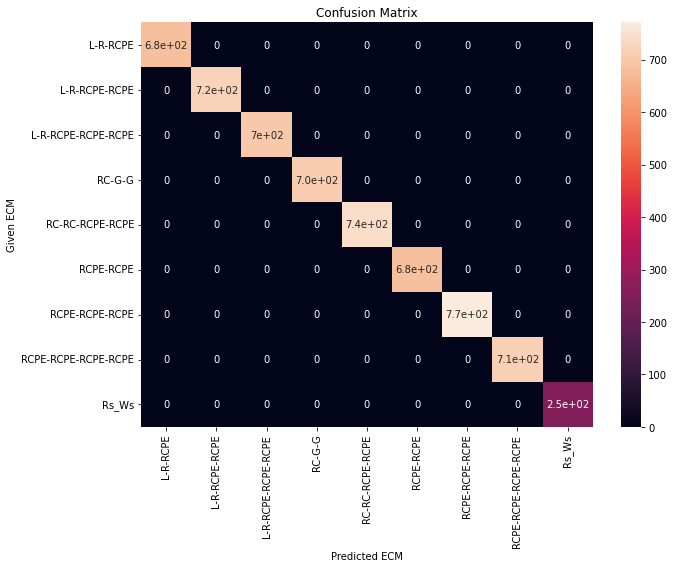

Train Accuracy: 1.0000


Feature Extraction: 100%|██████████| 25/25 [00:18<00:00,  1.35it/s]


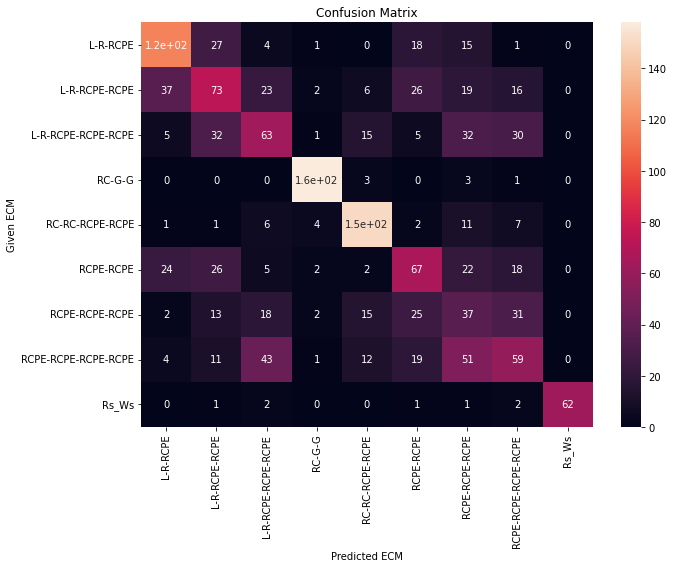

Test Accuracy: 0.5265


In [5]:
# If label encodes is not availble (e.g. this script is separated, uncommenitng the folling lines allows to restore the same encoder that encoded the training data)
with open(f"data/le_name_mapping.json", "r") as f:
   label_dict = json.load(f)
le = LabelEncoder()
classes = np.array([label_dict[str(i)] for i in range(9)])
le.classes_ = classes

if not load_features:
    df = preprocess_data(d_path + "train_data_newspl.csv")

    # For tsfresh we need to 'unwrap' all the measurements into a dataframe with measurement ids, freq, zreal, and zimag columns
    df_ts = unwrap_df(df)

    if verbose:
        print(df_ts.shape, len(np.unique(df_ts["id"])))
        print(df_ts.head)

    # Creating labels y
    df_x = pd.DataFrame(index=np.unique(df_ts["id"]))
    df_y = pd.Series(data=(le.transform(df["Circuit"])), index=np.unique(df_ts["id"]))

    if extra_train_split:
        # Section with train test spplit taking only data that was availble to the participants
        # The data is splitted here for development purposes, because the labeled test data was not available to the participants during the hackathon
        X_train, X_test, y_train, y_test = train_test_split(df_x, df_y, test_size=0.2, random_state=42)

        ppl = create_pipeline_clf(df_ts)
        ppl.fit(X_train, y_train)
        y_train_pred = predict_plot_cm(ppl, X_train, y_train, le, save=save_fig, str='Train', save_path=fig_path, figname="train_confusion")
        y_test_pred = predict_plot_cm(ppl, X_test, y_test, le, save=save_fig, str='Test', save_path=fig_path, figname="test_confusion")
    else:
        # X contains just id's, this is due to the way ts fresh has to be set up with pipelines. 
        X_train = df_x
        y_train = df_y

        ppl = create_pipeline_clf(df_ts)
        ppl.fit(X_train, y_train)
        y_train_pred = predict_plot_cm(ppl, X_train, y_train, le, save=save_fig, str='Train', save_path=fig_path, figname="train_confusion")

        # Now lets process to the test data.

        df_test = preprocess_data(d_path + "test_data_newspl.csv")
        df_ts_test = unwrap_df(df_test)

        X_test = pd.DataFrame(index=np.unique(df_ts_test["id"]))
        y_test = pd.Series(data=(le.transform(df_test["Circuit"])), index=np.unique(df_ts_test["id"]))

        # Important step to pass the test data X to the pipeline. Important: df_ts_test does not coantin any labels y!
        ppl.set_params(augmenter__timeseries_container=df_ts_test);
        y_test_pred = predict_plot_cm(ppl, X_test, y_test, le, save=save_fig, str='Test', save_path=fig_path, figname="test_confusion")

        if save_model:
            name = 'extrasplit-' if extra_train_split else 'all-'
            dump(ppl, f'xgb-tsfresh-clf-{name}train-data-pipeline.joblib') 
else:
    train_data_f = "data/umap_train.csv"
    test_data_f = "data/umap_test.csv"
    le_f = "data/le_name_mapping.json"

    X_train, y_train, X_test, y_test, le = load_features_le(train_data_f, test_data_f, le_f)

    # Create XGBoost model
    model = xgb.XGBClassifier(random_state=42, n_jobs=-1)
    model.fit(X_train, y_train)

    # Make predictions for train data
    y_train_pred = model.predict(X_train)
    y_train_pred = predict_plot_cm(model, X_train, y_train, le, save=save_fig, str='Train', save_path=fig_path, figname="train_confusion")

    # Make predictions for test data
    y_test_pred = model.predict(X_test)
    y_test_pred = predict_plot_cm(model, X_test, y_test, le, save=save_fig, str='Test', save_path=fig_path, figname="test_confusion")

    if save_model:
        dump(model, 'xgb-tsfresh-clf-model.joblib')

In [6]:

def XGB_tuning(space, X_train, y_train, X_test, y_test):
    clf=xgb.XGBClassifier(
                    n_estimators =space['n_estimators'], max_depth = int(space['max_depth']), gamma = space['gamma'],
                    reg_alpha = int(space['reg_alpha']),min_child_weight=int(space['min_child_weight']),
                    colsample_bytree=int(space['colsample_bytree']))
    
    evaluation = [( X_train, y_train), ( X_test, y_test)]
    
    clf.fit(X_train, y_train,
            eval_set=evaluation, eval_metric="auc",
            early_stopping_rounds=10,verbose=False)
    

    pred = clf.predict(X_test)
    accuracy = f1_score(y_test, pred>0.5)
    print ("SCORE:", accuracy)
    return {'loss': -accuracy, 'status': STATUS_OK }

Feature Extraction: 100%|██████████| 25/25 [00:19<00:00,  1.30it/s]
ntree_limit is deprecated, use `iteration_range` or model slicing instead.


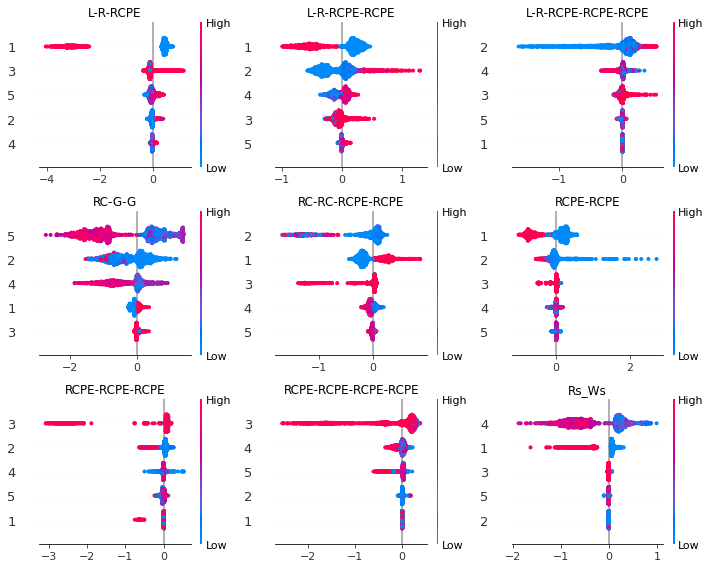

In [7]:
# Display relevant features
# ppl.named_steps["augmenter"].feature_selector.relevant_features

if shap_analysis:
    if not load_features:
        mdl = ppl['classifier']
        x_transformed = ppl['augmenter'].transform(X_test)
    else:
        mdl =  model
        x_transformed = X_test
    shap_feature_analysis(mdl, x_transformed, le)